In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import parent
import networks

In [3]:
from collections import OrderedDict
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import network_wrappers
import data
import numpy as np
import matplotlib.pyplot as plt

In [4]:
r_ds = torch.load("/playpen/tgreer/knees_test_set")
batched_ds = list(zip(r_ds[::3], r_ds[1::3], r_ds[2::3]))

In [5]:
BATCH_SIZE = 32
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 4


phi = network_wrappers.FunctionFromMatrix(
    networks.StumpyConvolutionalMatrixNet(dimension=3)
)
psi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet2(dimension=3)
)

net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(phi, psi),
    lambda x, y: torch.mean((x - y) ** 2),
    100,
)

network_wrappers.assignIdentityMap(net, input_shape)

/playpen-raid1/tgreer/InverseConsistency/networks.py:483: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[2, 16, 32, 64, 256, 512], [16, 32, 64, 128, 256]]),


In [20]:
def adjust_batch_size(model, size):
    shape = model.input_shape
    shape[0] = size
    network_wrappers.assignIdentityMap(model, shape)

adjust_batch_size(net, 32)

trained_weights = torch.load("../results/affine_deformable_knee_nopretrain3/knee_aligner_resi_net10200")


In [7]:
net.load_state_dict(trained_weights)

<All keys matched successfully>

In [8]:
trained_weights_affine = torch.load("../results/affine_knee_pretrain_2/knee_aligner_resi_net45900")


In [9]:
[k for k in trained_weights_affine.keys() if "identityMap" in k]

['identityMap',
 'regis_net.identityMap',
 'regis_net.netPsi.identityMap',
 'regis_net.netPsi.net.identityMap',
 'regis_net.netPsi.net.convs.identityMap',
 'regis_net.netPsi.net.convs.0.identityMap',
 'regis_net.netPsi.net.convs.1.identityMap',
 'regis_net.netPsi.net.convs.2.identityMap',
 'regis_net.netPsi.net.convs.3.identityMap',
 'regis_net.netPsi.net.convs.4.identityMap',
 'regis_net.netPsi.net.dense2.identityMap',
 'regis_net.netPsi.net.dense3.identityMap',
 'regis_net.netPhi.identityMap',
 'regis_net.netPhi.net.identityMap',
 'regis_net.netPhi.net.convs.identityMap',
 'regis_net.netPhi.net.convs.0.identityMap',
 'regis_net.netPhi.net.convs.1.identityMap',
 'regis_net.netPhi.net.convs.2.identityMap',
 'regis_net.netPhi.net.convs.3.identityMap',
 'regis_net.netPhi.net.convs.4.identityMap',
 'regis_net.netPhi.net.dense2.identityMap',
 'regis_net.netPhi.net.dense3.identityMap']

In [10]:
adjust_batch_size(net, 3)
net.cuda()
net.eval()

InverseConsistentNet(
  (regis_net): DoubleNet(
    (netPsi): FunctionFromVectorField(
      (net): UNet2(
        (downConvs): ModuleList(
          (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (3): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (4): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        )
        (upConvs): ModuleList(
          (0): ConvTranspose3d(48, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
          (1): ConvTranspose3d(96, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
          (2): ConvTranspose3d(192, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
          (3): ConvTranspose3d(512, 128, kernel_size=(4, 4, 4), strid

In [11]:
dices = []
for x in batched_ds:
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    
    net(moving_image, fixed_image)
    fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB(net.identityMap)[:, :3])
    sz = np.array(fat_phi.size())
    spacing = 1./(sz[2::]-1) 
    warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
    wmb = warped_moving_cartilage > .5
    fb = fixed_cartilage > .5
    intersection = wmb * fb
    d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
    print(d)
    dices.append(d)
dd = np.mean([d.item() for d in dices])
print(dd)

/playpen-raid1/tgreer/anaconda3/envs/mermaid5/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(0.5265, device='cuda:0')
tensor(0.4145, device='cuda:0')
tensor(0.5443, device='cuda:0')
tensor(0.5521, device='cuda:0')
tensor(0.5169, device='cuda:0')
tensor(0.4697, device='cuda:0')
tensor(0.4167, device='cuda:0')
tensor(0.3222, device='cuda:0')
tensor(0.4718, device='cuda:0')
tensor(0.4595, device='cuda:0')
tensor(0.5010, device='cuda:0')
tensor(0.4582, device='cuda:0')
tensor(0.4314, device='cuda:0')
tensor(0.5360, device='cuda:0')
tensor(0.3548, device='cuda:0')
tensor(0.5191, device='cuda:0')
tensor(0.4063, device='cuda:0')
tensor(0.4343, device='cuda:0')
tensor(0.4196, device='cuda:0')
tensor(0.4952, device='cuda:0')
tensor(0.4765, device='cuda:0')
tensor(0.4923, device='cuda:0')
tensor(0.4565, device='cuda:0')
tensor(0.5456, device='cuda:0')
tensor(0.4631, device='cuda:0')
tensor(0.4916, device='cuda:0')
tensor(0.4778, device='cuda:0')
tensor(0.3397, device='cuda:0')
tensor(0.4574, device='cuda:0')
tensor(0.4814, device='cuda:0')
tensor(0.4832, device='cuda:0')
tensor(0

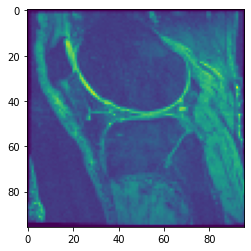

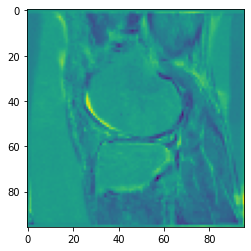

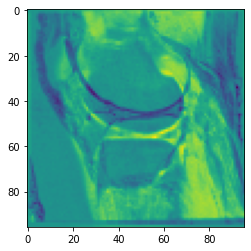

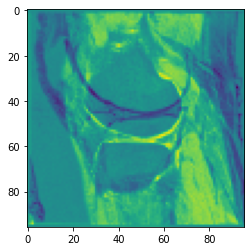

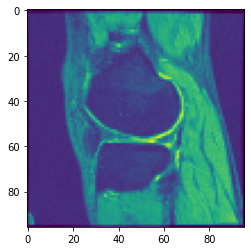

In [13]:
if not("N" in locals()):
    N = 0
N += 1
N %= 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()

plt.imshow(moving_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_A[N, 0, 10].cpu().detach() - fixed_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(net.regis_net.x_comp_phi[N, 0, 10].cpu().detach() - moving_image[N, 0, 10].cpu().detach())
plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, 10].cpu().detach())
plt.show()
plt.imshow(fixed_image[N, 0, 10].cpu().detach())
plt.show()

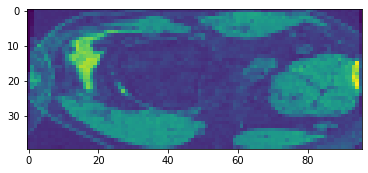

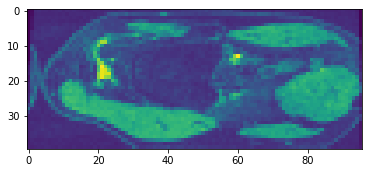

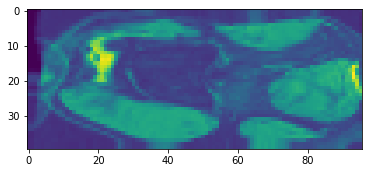

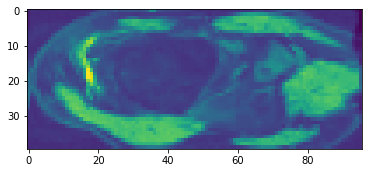

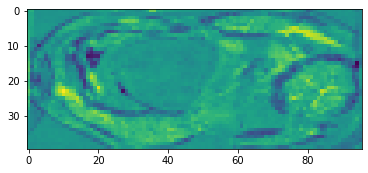

In [14]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

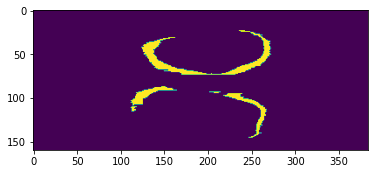

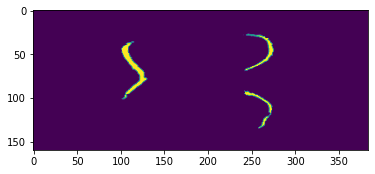

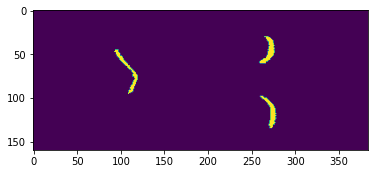

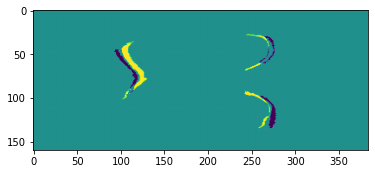

In [15]:
#N +=1
N %= 3
S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

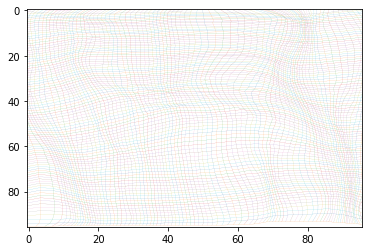

In [18]:
import visualize
visualize.show_as_grid(net.phi_AB_vectorfield[2, [1, 2], 20])

tensor([[[ 1.0144e+00, -1.4725e-02, -2.0055e-02,  6.3593e-03],
         [ 9.5594e-04,  1.0146e+00,  5.3511e-03,  8.0860e-04],
         [ 1.5067e-02, -6.3062e-03,  1.0077e+00, -1.7288e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 9.7454e-01, -1.0601e-02, -8.8819e-03,  1.7068e-02],
         [ 4.2222e-03,  9.9989e-01,  5.0027e-03, -3.4177e-04],
         [-5.8819e-03, -3.8857e-03,  9.8886e-01,  2.7959e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],

        [[ 1.0425e+00,  1.1575e-02,  1.2502e-02, -2.9236e-02],
         [-5.9480e-03,  9.9934e-01, -1.0445e-02, -1.9113e-03],
         [-5.1858e-03,  1.8575e-02,  1.0388e+00, -1.6596e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0', grad_fn=<UnsafeViewBackward>)

In [41]:
isinstance(net.regis_net.netPhi.net.convs[0], torch.nn.Module)

True

In [45]:
type(net.regisNet.netPhi)

ModuleAttributeError: 'InverseConsistentNet' object has no attribute 'regisNet'